<i><b>Public AI</b></i>
<br>

# Padding & Strides

### _Objective_

1. 합성곱 연산 전후 특징맵의 크기를 보존해주는 패딩에 대해 배워보도록 하겠습니다.<br>
2. 합성곱 연산량을 줄여주는 스트라이드(Stride)에 대해 배워보도록 하겠습니다.
  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

# \[ 1. 패딩이란 \]

----

합성곱 연산을 거치게 되면, 특징맵의 크기는 약간씩 줄게 됩니다. 패딩은 합성곱 연산을 거치더라도, 특징맵의 크기가 줄어들지 않도록 만듭니다.


## 1. 합성곱 연산의 문제점 : 크기의 축소


합성곱 연산을 적용할 경우, 특징맵의 가장자리 부분은 연산에서 제외되기 때문에 약간씩 줄어들게 됩니다.

![Imgur](https://i.imgur.com/gBUh9dG.png)

### (1) 예제 이미지 구성하기

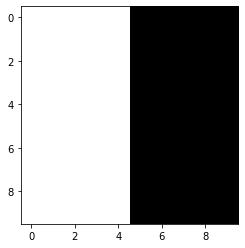

In [2]:
image = np.zeros((10, 10),dtype=np.uint8)
image[:,:5] = 10

plt.imshow(image, cmap='gray')
plt.show()

### (2) 세로방향 Sobel 필터인 모델 구성하기

In [3]:
# 모델 구성하기
inputs = Input(shape=(None, None, 1))
conv_1 = Conv2D(1, 3, use_bias=False, name='conv_1')(inputs)
model = Model(inputs, conv_1)

# 소벨 필터 구성하기
v_sobel = np.array([[1,0,-1], 
                    [2,0,-2], 
                    [1,0,-1]]) 
res_v_sobel = v_sobel.reshape(3,3,1,1)

# 소벨필터 값을 모델에 적용하기
model.get_layer('conv_1').set_weights([res_v_sobel])

In [4]:
# Get result 
res_image = image[None,:,:,None]
result = model.predict(res_image)
result = np.squeeze(result)

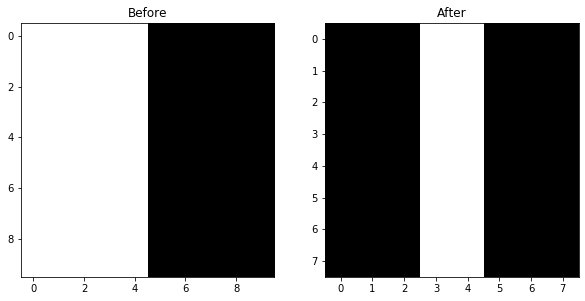

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.set_title('Before')
ax.imshow(image, cmap='gray')

ax = fig.add_subplot(1,2,2)
ax.set_title('After')
ax.imshow(result, cmap='gray')
plt.show()

In [6]:
print("원본 이미지의 크기 : {}".format(image.shape))
print("결과 이미지의 크기 : {}".format(result.shape))

원본 이미지의 크기 : (10, 10)
결과 이미지의 크기 : (8, 8)


원본 이미지 대비 결과 이미지의 크기가 가로 방향 세로 방향 모두 2씩 줄어든 것을 확인할 수 있습니다.<br>

## 2. Padding이란

합성곱 연산을 할때마다 조금씩 이미지의 크기가 줄어듭니다. 이는 크게 2가지 문제를 유발합니다.

1. 깊게 쌓으면 이미지의 크기가 지나치게 작아지게 됨 <br>
2. 가장자리의 정보가 계속 유실되게 됨 <br>

이러한 문제를 해결하기 위해, 가장자리에 이미지를 덧대주는 작업을 거치게 됩니다.

### (1) 패딩 적용하기


In [12]:
print("Before Feature Map size :",image.shape)
pad_height = np.zeros((1,10))
image_with_pad_height = np.concatenate([pad_height,image,pad_height],axis=0)

pad_width = np.zeros((12,1))
image_with_pad = np.concatenate([pad_width,image_with_pad_height,pad_width],axis=1)

#image_with_pad = # FIXME
print("After padding size :",image_with_pad.shape)

Before Feature Map size : (10, 10)
After padding size : (12, 12)


`np.pad`를 이용하면 좀 더 편하게 작업할 수 있습니다.

In [23]:
print("Before Feature Map size :",image.shape)
image_with_pad = np.pad(image, pad_width = [(1,1),(1,1)]
                       , mode = 'constant')
print("After padding size :",image_with_pad.shape)

Before Feature Map size : (10, 10)
After padding size : (12, 12)


당연히 Tensorflow에서도 구현이 되어 있습니다.

In [18]:
print("Before Feature Map size :",image.shape)
image_with_pad = tf.pad(image, pad_width = [(1,1),(1,1)]
                       , mode = 'constant')
print("After padding size :",image_with_pad.shape)

Before Feature Map size : (10, 10)


TypeError: pad_v2() got an unexpected keyword argument 'pad_width'

### (2) 모델 적용하기

In [19]:
# Get result 
res_image = image_with_pad[None,:,:,None]
result = model.predict(res_image)
result = np.squeeze(result)

print("After Feature Map size :",result.shape)

After Feature Map size : (10, 10)


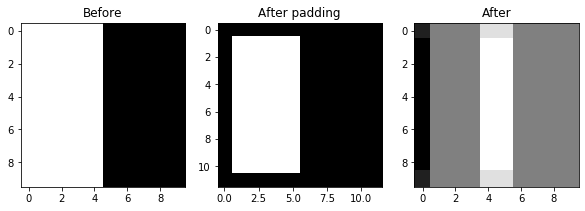

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1)
ax.set_title('Before')
ax.imshow(image, cmap='gray')

ax = fig.add_subplot(1,3,2)
ax.set_title('After padding')
ax.imshow(image_with_pad, cmap='gray')

ax = fig.add_subplot(1,3,3)
ax.set_title('After')
ax.imshow(result, cmap='gray')
plt.show()

Input과 Output의 크기가 동일합니다.<br>
작은 이미지에서는 패딩에 의해, 결과가 약간씩 왜곡되지만, 실제로 대부분 이미지에서<br>
패딩으로 인한 왜곡 현상은 무시할 수 있을 만큼 작습니다.

<br>

## 3. 패딩의 크기 결정

텐서플로우에서도 Convolution 에 padding 을 쉽게 적용 가능합니다. <br>
Convolution에서 패딩의 크기를 결정하는 것에는 크게 2가지 방식이 존재합니다.



1. VALID :  패딩을 붙이지 않습니다. Window 에 Kernel 의 사이즈 보다 적은 데이터 셋이 있다면 Convolution 연산을 수행하지 않습니다. 

![Imgur](https://i.imgur.com/uVU6FlS.png)

2. SAME : Convoluiton 연산을 수행하기 위해 이미지에 padding 을 붙입니다.  Window 에 Kernel 의 사이즈 보다 적은 데이터 셋이 있다면 padding 을 붙여 Convolution 을 수행합니다.

![Imgur](https://i.imgur.com/gBvXhZw.png)

### (1) SAME 시 패딩의 크기를 결정하기

출력의 크기는 아래와 같이 결정됩니다.<br>
$$
n_{out} = n_{in}+2p-k +1\\
-------------\\
n_{in} : \mbox{number of input features}\\
n_{out} : \mbox{number of output features}\\
k : \mbox{convolution kernel size}\\
p : \mbox{convolution padding size}\\
$$

출력의 크기와 입력의 크기가 동일하게 만들어주기 위해서는<br>
패딩의 크기가 아래와 같아져야 합니다.<br>
$$
p = \frac{k-1}{2}
$$

### (2) 필터의 크기


필터의 크기는 보통 홀수로 정합니다. 그 이유는 크게 2가지로 
1. 짝수의 경우, 패딩의 크기를 좌우 비대칭으로 형성해야 함
   
2. 필터의 크기가 홀수일 경우, 가운데 필터 값이 중심 픽셀에 위치

## 4. Conv2D 함수에 padding 적용하기 

`tensorflow.keras.layers.Conv2D` 함수에 `same`, `valid` padding 알고리즘을 적용하는 법을 배워보고 결과를 확인합니다. 

default 값은 `valid` 로 되어 있습니다
<img src = "https://i.imgur.com/RNsXx9O.png" width="400">


### (1) 패딩 타입이 Valid인 경우

In [24]:
# 합성곱 연산 적용 with Keras 
inputs = Input(shape=(10, 10, 1))
conv_1 = Conv2D(1, 3 ,use_bias=False, 
                padding='valid', name='conv_1')(inputs)

# Model 
model = Model(inputs, conv_1)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 8, 8, 1)           9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


### (2) 패딩 타입이 `same`인 경우

In [25]:
# 합성곱 연산 적용 with Keras 
inputs = Input(shape=(10, 10, 1))
conv_1 = Conv2D(1, 3, use_bias=False, 
                padding='same', name='conv_1')(inputs)

# Model 
model = Model(inputs, conv_1)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 10, 10, 1)         9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


# \[ 2. 스트라이드란 \]

----

Window 는 Image 에 filter 가 적용되는 공간을 의미 합니다. stride는 window의 이동 간격을 뜻합니다. 기존의 필터는 한칸씩 이동했다면, stride가 1보다 클 경우, 그 수 만큼 필터가 이동하게 됩니다.
<img src="https://i.imgur.com/qcsl6sz.png" width="400">

## 1. 스트라이드 적용하기

Stride는 대표적으로 영상의 출력값 크기를 결정짓는 요인입니다. Stride에 따라 어떤 식으로 영상 크기가 바뀌는지를 보도록 하겠습니다.

### (1) (2, 2) 스트라이드 적용하기


#### Padding이 Valid인 경우
$$
n_{out} = \lfloor \frac{n_{in} - k}{s}\rfloor +1\\
-------------\\\
n_{in} : \mbox{number of input features}\\
n_{out} : \mbox{number of output features}\\
k : \mbox{convolution kernel size}\\
s : \mbox{convolution stride size}\\
$$


In [12]:
# 합성곱 연산 적용 with Keras 
inputs = Input(shape=(10, 10, 1))

conv_0 = Conv2D(1, 3, strides=(2, 2), name='conv_0')(inputs)

# Model 
model = Model(inputs, conv_0)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 4, 4, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


#### Padding이 SAME인 경우
$$
n_{out} = \lceil \frac{n_{in}}{s}\rceil \\
-------------\\\
n_{in} : \mbox{number of input features}\\
n_{out} : \mbox{number of output features}\\
s : \mbox{convolution stride size}\\
$$


In [13]:
# 합성곱 연산 적용 with Keras 
inputs = Input(shape=(10, 10, 1))

conv_0 = Conv2D(1, 3, strides=(2, 2), 
                padding='SAME', name='conv_0')(inputs)

# Model 
model = Model(inputs, conv_0)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 5, 5, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### (2) (3, 3) 스트라이드 적용하기

#### Padding이 Valid인 경우
$$
n_{out} = \lfloor \frac{n_{in} - k}{s}\rfloor +1\\
-------------\\\
n_{in} : \mbox{number of input features}\\
n_{out} : \mbox{number of output features}\\
k : \mbox{convolution kernel size}\\
s : \mbox{convolution stride size}\\
$$


In [14]:
# 합성곱 연산 적용 with Keras 
inputs = Input(shape=(10, 10, 1))

conv_0 = Conv2D(1, 3, strides=(3, 3), name='conv_0')(inputs)

# Model 
model = Model(inputs, conv_0)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 3, 3, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


#### Padding이 SAME인 경우
$$
n_{out} = \lceil \frac{n_{in}}{s}\rceil \\
-------------\\\
n_{in} : \mbox{number of input features}\\
n_{out} : \mbox{number of output features}\\
s : \mbox{convolution stride size}\\
$$


In [15]:
# 합성곱 연산 적용 with Keras 
inputs = Input(shape=(10, 10, 1))

conv_0 = Conv2D(1, 3 ,strides=(3, 3), 
                padding='SAME',name='conv_0')(inputs)

# Model 
model = Model(inputs, conv_0)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 4, 4, 1)           10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


---
⊙ Copyright(c) 2020 by PublicAI. All rights reserved <br>
All pictures, codes, writings cannot be copied without permission. <br>
Writen by PAI(info@publicai.co.kr) <br>
last updated on 2020/01/4 <br>

---